In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_STRIDE = 10
FC_START = "2022-08-31 23:00:00+00:00"

path=r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/data/wattsight_database/pri_de_spot_€mwh_cet_min15_a_2022.csv"

price_timeseries = pd.read_csv(path,
            decimal=",",
            sep=";",
            index_col=0,
        )
# price_timeseries.loc[:,"datetime_utc"] = pd.to_datetime(
#     price_timeseries.index, utc=True
# )

price_timeseries.index = pd.to_datetime(price_timeseries.index, utc=True)
price_timeseries.index.name = "datetime_utc"

price_timeseries.rename(
     columns={"pri de spot €/mwh cet min15 a": "price_eur_mwh"}, inplace=True
 )


/home/sairam/thesisvenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(price_timeseries)


                           price_eur_mwh
datetime_utc                            
2021-12-31 23:00:00+00:00         100.06
2021-12-31 23:15:00+00:00          67.64
2021-12-31 23:30:00+00:00          51.35
2021-12-31 23:45:00+00:00          41.36
2022-01-01 00:00:00+00:00          76.13
...                                  ...
2022-12-02 21:45:00+00:00         232.94
2022-12-02 22:00:00+00:00         339.89
2022-12-02 22:15:00+00:00         279.34
2022-12-02 22:30:00+00:00         220.42
2022-12-02 22:45:00+00:00         187.05

[32256 rows x 1 columns]


In [3]:
price_timeseries.describe()

,price_eur_mwh
count,32256.000000
mean,233.559653
std,145.695487
min,-99.990000
25%,135.087500
50%,203.085000
75%,307.070000
max,980.890000


<Axes: xlabel='datetime_utc'>

<Figure size 1200x500 with 0 Axes>

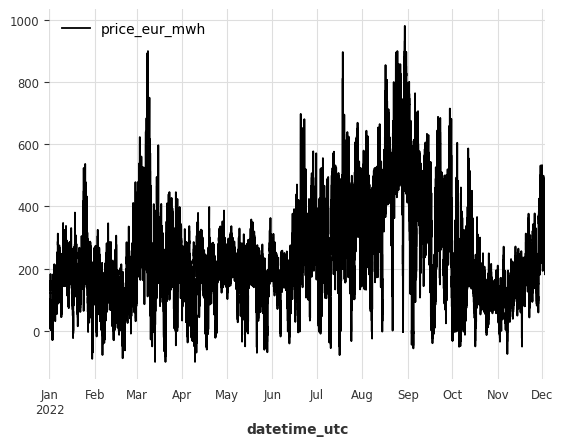

In [4]:
plt.figure(100,figsize=(12,5))
price_timeseries.plot()


In [5]:
#ts = price_timeseries['price_eur_mwh']
ts = price_timeseries
from darts import TimeSeries

# 'price_series' is the pandas Series
ts = TimeSeries.from_series(ts)

len(ts)
type(ts)

darts.timeseries.TimeSeries

In [6]:
# analyze its seasonality
is_seasonal, periodicity = check_seasonality(ts, max_lag=len(ts))
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 4.0
periodicity (~years) : 0.3


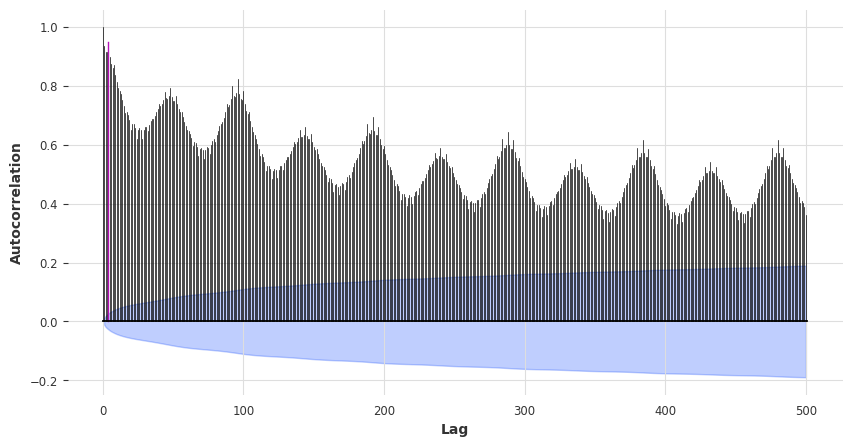

In [7]:
import os
path = "/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNplots/"
plot_acf(ts,periodicity,max_lag=500)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
#plt.title(f"Autocorrelation Function (ACF) with Max Lag {max_lag} and Periodicity {periodicity}")
plt.grid(True)
plt.savefig(os.path.join(path, "autocorr.png"), dpi=400, bbox_inches='tight')
plt.show()

In [8]:

# from darts.datasets import AirPassengersDataset
# FC_START1 = "19590101"  
# series = AirPassengersDataset().load()
# print("Time series length:", len(series))

# year_series = datetime_attribute_timeseries(
#     pd.date_range(start=series.start_time(), 
#         freq=series.freq_str, 
#         periods=1000),
#     attribute='year', 
#     one_hot=False)

# year_series = Scaler().fit_transform(year_series)

# month_series = datetime_attribute_timeseries(
#     year_series, 
#     attribute='month', 
#     one_hot=True)

# covariates = year_series.stack(month_series)
# cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START1))
# len(cov_train)


In [9]:

import pytz

FC_START = pd.Timestamp(year=2022, month=8, day=31, hour=0, minute=0, second=0)

train, val = ts.split_after(FC_START)
print(train)
print(val)

print(len(train))
print(len(val))


<TimeSeries (DataArray) (datetime_utc: 23237, component: 1, sample: 1)>
array([[[100.06]],

       [[ 67.64]],

       [[ 51.35]],

       ...,

       [[512.03]],

       [[532.82]],

       [[501.91]]])
Coordinates:
  * datetime_utc  (datetime_utc) datetime64[ns] 2021-12-31T23:00:00 ... 2022-...
  * component     (component) object 'price_eur_mwh'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
<TimeSeries (DataArray) (datetime_utc: 9019, component: 1, sample: 1)>
array([[[498.79]],

       [[519.28]],

       [[532.85]],

       ...,

       [[279.34]],

       [[220.42]],

       [[187.05]]])
Coordinates:
  * datetime_utc  (datetime_utc) datetime64[ns] 2022-08-31T00:15:00 ... 2022-...
  * component     (component) object 'price_eur_mwh'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
23237
9019


In [10]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [11]:

# start_timestamp = pd.Timestamp(year=2021, month=12, day=31, hour=23, minute=0, second=0, tz='UTC')
# end_timestamp = pd.Timestamp(year=2022, month=12, day=2, hour=22, minute=45, second=0, tz='UTC')

# num_periods = (end_timestamp - start_timestamp) // pd.Timedelta(minutes=15)
# print("Number of periods:", num_periods)

year_series = datetime_attribute_timeseries(
    pd.date_range(start=ts.start_time(), 
        freq=ts.freq_str, 
        periods=len(ts)),
    attribute='month', 
    one_hot=False)

year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='week', 
    one_hot=True)

covariates = year_series.stack(month_series)

FC_START = pd.Timestamp(year=2022, month=8, day=31, hour=0, minute=0, second=0)
cov_train, cov_val = covariates.split_after(FC_START)
print(len(cov_val))

9019


In [ ]:
from darts.models import RNNModel
FC_N = 291
EPOCH = 1
import pickle
import torch

#ACTUALPATH
modelpathLSTM = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/LSTM.pt"
modelpathVanilla = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/Vanilla.pt"
modelpathGRU = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/GRU.pt"
modelpathTheta = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/Theta.pt"

# #TEST PATH
# modelpathLSTM = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModelsTest/LSTM.pt"
# modelpathVanilla = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModelsTest/Vanilla.pt"
# modelpathGRU = r"E:/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModelsTest/GRU.pt"
# modelpathTheta = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/Theta.pt"

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)
    #model_RNN= model_RNN()
    
    if flavor == "LSTM":
        model_RNN.save(modelpathLSTM)
    elif flavor == "GRU":
        model_RNN.save(modelpathGRU)
    else:
        model_RNN.save(modelpathVanilla)
    
    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
    
    

# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')
    
    # if flavor == "LSTM":
    #     model.save(modelpathLSTM)
    # elif flavor == "GRU":
    #     model.save(modelpathGRU)
    # else:
    #     model.save(modelpathVanilla)
    return res


def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend()

def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

# run 3 different flavors of RNN on the time series:
#flavors = ["LSTM", "GRU", "RNN"]
#flavors = ["RNN"]
flavors = ["LSTM"]

# call the RNN model setup for each of the 3 RNN flavors
[run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
LSTM : 
MAPE : 31.3344
RMSPE : 1.2777
RMSE : 0.2267
-R squared : 14.1005
se : 0.3804
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
GRU : 
MAPE : 235.9153
RMSPE : 1.0249
RMSE : 0.2880
-R squared : 0.8621
se : 0.4874
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]
RNN : 
MAPE : 370.4285
RMSPE : 1.0972
RMSE : 0.3918
-R squared : 0.6567
se : 0.5690


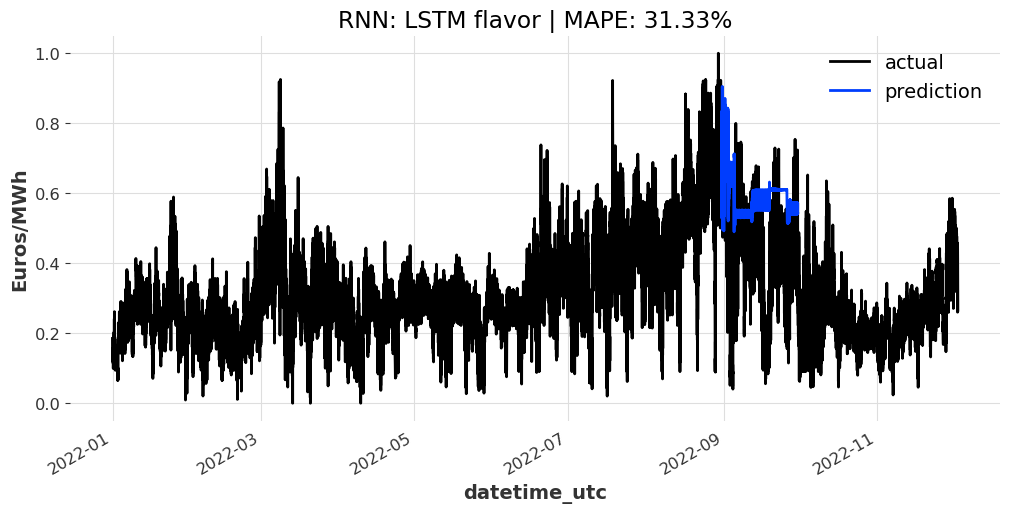

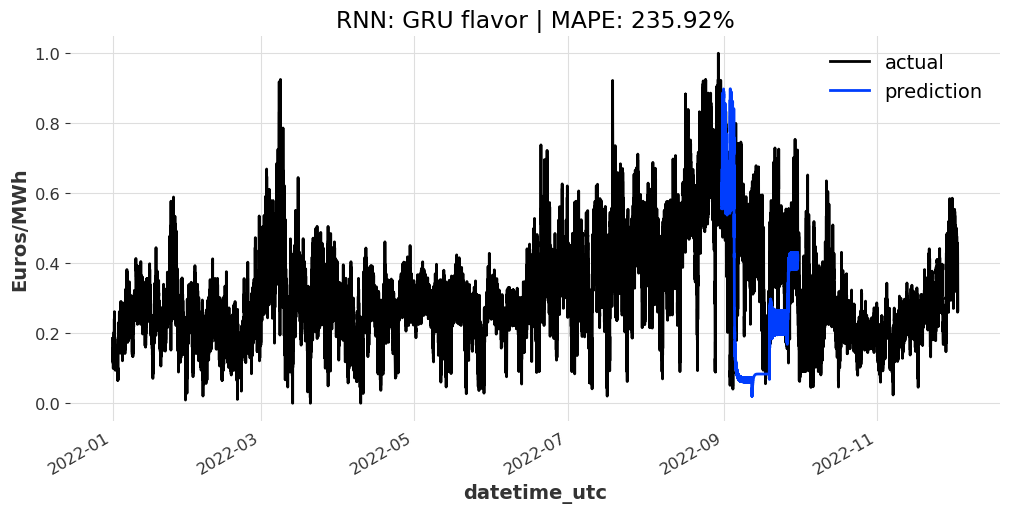

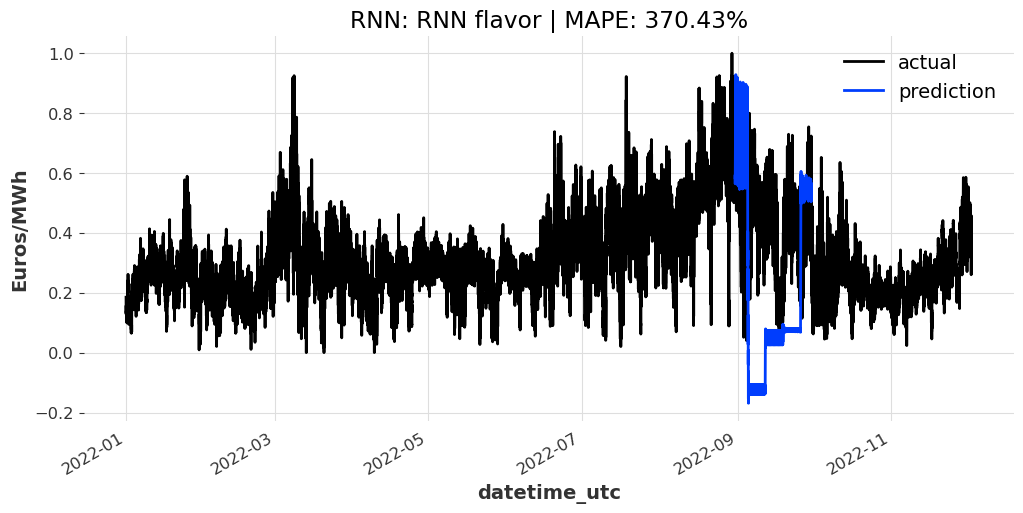

In [13]:
import os
path = "/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNplots/"
def plot_fitted(pred, act, flavor, FC_N):
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.ylabel('Euros/MWh')
    plt.savefig(os.path.join(path, "RNN_{0} flavor".format(flavor) + "_" + str(FC_N) + "_len.png"), dpi=400, bbox_inches='tight')
    
    plt.legend()

def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy
    
# helper function: plot the predictions
ts = ts_trf
from darts.models import RNNModel
FC_N = 2910
#Actual PATH
modelpathLSTM = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/LSTM.pth"
modelpathVanilla = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/Vanilla.pt"
modelpathGRU = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/GRU.pt"
modelpathTheta = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/Theta.pt"

# #TEST PATH
# modelpathLSTM = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModelsTest/LSTM.pt"
# modelpathVanilla = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModelsTest/Vanilla.pt"
# modelpathGRU = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModelsTest/GRU.pt"
# modelpathTheta = r"/home/sairam/evap-flex-aggregation/evap_flex_aggregation/fxt_optimizer/CostProfileGenerator/RNNModels/Theta.pt"


model_RNN = RNNModel.load(modelpathLSTM)
# compute N predictions
pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 
flavor = "LSTM"
# plot predictions vs actual
plot_fitted(pred, ts, flavor, FC_N)

# print accuracy metrics
res_acc = accuracy_metrics(pred, ts)    
print(flavor + " : ")
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]


model_RNN = RNNModel.load(modelpathGRU)
flavor = "GRU"
# compute N predictions
pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

# plot predictions vs actual
plot_fitted(pred, ts, flavor, FC_N)

# print accuracy metrics
res_acc = accuracy_metrics(pred, ts)    
print(flavor + " : ")
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

flavor = "RNN"
model_RNN = RNNModel.load(modelpathVanilla)

pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

# plot predictions vs actual
plot_fitted(pred, ts, flavor, FC_N)

# print accuracy metrics
res_acc = accuracy_metrics(pred, ts)    
print(flavor + " : ")
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

